<a href="https://colab.research.google.com/github/snehjn1407/AI-ML-projects/blob/main/BitcoinMarketSentiment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 0: Setup environment (run once)
# If packages are already present this will be quick; install gdown and any missing libs
!pip install -q gdown pandas scipy scikit-learn matplotlib

# Optional: mount Google Drive if you prefer to save results there
from google.colab import drive
# drive.mount('/content/drive')   # uncomment if you want to mount your Drive

# Imports
import os
import io
import zipfile
import warnings
warnings.filterwarnings("ignore")

import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict

# For stats and modeling
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Repro
RSEED = 42
np.random.seed(RSEED)


In [ ]:
# Replace these IDs with the ones from your links (these are from your message)
trades_file_id = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
sentiment_file_id = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

def download_drive_file(file_id, out_name):
    url = f"https://drive.google.com/uc?id={file_id}"
    print("Downloading", out_name)
    gdown.download(url, out_name, quiet=False)
    return out_name

trades_local = download_drive_file(trades_file_id, "historical_trades_download")
sentiment_local = download_drive_file(sentiment_file_id, "fear_greed_download")


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_trades_download
100%|██████████| 47.5M/47.5M [00:00<00:00, 145MB/s]


Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_download
100%|██████████| 90.8k/90.8k [00:00<00:00, 40.7MB/s]


In [ ]:
# Utility to try multiple readers
def try_read_any(path):
    # if path is a zip file, try to extract and read inside
    def try_csv(p): return pd.read_csv(p)
    def try_excel(p): return pd.read_excel(p)
    def try_parquet(p): return pd.read_parquet(p)
    readers = [try_csv, try_excel, try_parquet]
    # Try direct reads
    for r in readers:
        try:
            df = r(path)
            print(f"Read with {r.__name__} -> shape {df.shape}")
            return df
        except Exception as e:
            #print("Failed", r.__name__, ":", e)
            pass
    # Try zip extraction
    try:
        with zipfile.ZipFile(path, 'r') as z:
            print("ZIP file detected, contents:", z.namelist())
            # try each file inside
            for fname in z.namelist():
                z.extract(fname, "extracted_files")
                fp = os.path.join("extracted_files", fname)
                for r in readers:
                    try:
                        df = r(fp)
                        print(f"Read {fname} inside zip with {r.__name__} -> shape {df.shape}")
                        return df
                    except:
                        pass
    except:
        pass
    raise ValueError("Could not read file. Try downloading manually or check file type.")

# Read the datasets
df_trades = try_read_any(trades_local)
df_sent = try_read_any(sentiment_local)

print("Trades shape:", df_trades.shape)
print("Sentiment shape:", df_sent.shape)


Read with try_csv -> shape (211224, 16)
Read with try_csv -> shape (2644, 4)
Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


In [ ]:
# Quick look
print("Trades columns:", list(df_trades.columns)[:50])
display(df_trades.head(3))
print("\nSentiment columns:", list(df_sent.columns)[:50])
display(df_sent.head(5))

# Normalize column names (lowercase, strip)
df_trades.columns = [str(c).strip() for c in df_trades.columns]
df_sent.columns = [str(c).strip() for c in df_sent.columns]


Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12



Sentiment columns: ['timestamp', 'value', 'classification', 'date']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
def find_col(df, keywords):
    cols = df.columns
    for k in keywords:
        for c in cols:
            if k.lower() in str(c).lower():
                return c
    return None

# For trades
time_col = find_col(df_trades, ['time','timestamp','date','datetime'])
account_col = find_col(df_trades, ['account','acct','user'])
price_col = find_col(df_trades, ['execution price','execution_price','exec_price','price','execution_price'])
size_col = find_col(df_trades, ['size','qty','quantity','amount'])
side_col = find_col(df_trades, ['side','direction','buy/sell'])
pnl_col = find_col(df_trades, ['closedpnl','closed_pnl','pnL','pnl','closedPnL','closed PnL','realized'])
leverage_col = find_col(df_trades, ['leverage','lev'])
symbol_col = find_col(df_trades, ['symbol','pair','market'])

print("Detected columns:")
print("time_col:", time_col)
print("account_col:", account_col)
print("price_col:", price_col)
print("size_col:", size_col)
print("side_col:", side_col)
print("pnl_col:", pnl_col)
print("leverage_col:", leverage_col)
print("symbol_col:", symbol_col)


Detected columns:
time_col: Timestamp IST
account_col: Account
price_col: Execution Price
size_col: Size Tokens
side_col: Side
pnl_col: Closed PnL
leverage_col: None
symbol_col: None


In [ ]:
# helper to get column or fallback None
def colname_or_none(name):
    return name if name in df_trades.columns else None

price_col = colname_or_none(price_col)
size_col = colname_or_none(size_col)
pnl_col = colname_or_none(pnl_col)
leverage_col = colname_or_none(leverage_col)
side_col = colname_or_none(side_col)

# Convert to numeric as possible
if price_col:
    df_trades['exec_price'] = pd.to_numeric(df_trades[price_col], errors='coerce')
else:
    df_trades['exec_price'] = np.nan

if size_col:
    df_trades['size_raw'] = pd.to_numeric(df_trades[size_col], errors='coerce')
else:
    df_trades['size_raw'] = np.nan

if pnl_col:
    df_trades['closed_pnl'] = pd.to_numeric(df_trades[pnl_col], errors='coerce')
else:
    df_trades['closed_pnl'] = np.nan

if leverage_col:
    df_trades['leverage'] = pd.to_numeric(df_trades[leverage_col], errors='coerce')
else:
    df_trades['leverage'] = np.nan

# side encoding (long/buy vs short/sell)
if side_col:
    df_trades['side'] = df_trades[side_col].astype(str).str.lower().str.strip()
    # canonical mapping
    df_trades['is_buy'] = df_trades['side'].apply(lambda x: 1 if 'buy' in x or 'long' in x else (0 if 'sell' in x or 'short' in x else np.nan))
else:
    df_trades['side'] = np.nan
    df_trades['is_buy'] = np.nan

# absolute notional
df_trades['notional'] = (df_trades['exec_price'].abs() * df_trades['size_raw'].abs()).replace({0: np.nan})
# normalized pnl if notional present (percentage)
df_trades['pnl_pct_of_notional'] = df_trades['closed_pnl'] / df_trades['notional']

# binary target
df_trades['is_profitable'] = (df_trades['closed_pnl'] > 0).astype(int)
df_trades[['exec_price','size_raw','notional','closed_pnl','pnl_pct_of_notional','is_profitable']].head()


,exec_price,size_raw,notional,closed_pnl,pnl_pct_of_notional,is_profitable
0,7.9769,986.87,7872.163303,0.0,0.0,0
1,7.9800,16.00,127.680000,0.0,0.0,0
2,7.9855,144.09,1150.630695,0.0,0.0,0
3,7.9874,142.98,1142.038452,0.0,0.0,0
4,7.9894,8.73,69.747462,0.0,0.0,0


In [ ]:
# Detect date and sentiment columns in df_sent
sent_date_col = find_col(df_sent, ['date','day','timestamp'])
sent_class_col = find_col(df_sent, ['classification','sentiment','label','fear','greed','index','classification'])

print("sent_date_col:", sent_date_col, "sent_class_col:", sent_class_col)
if sent_date_col is None:
    raise ValueError("Couldn't detect a date column in the sentiment file. Inspect df_sent.columns")

# Parse date (we want a daily date)
df_sent['date'] = pd.to_datetime(df_sent[sent_date_col], errors='coerce').dt.date

# If classification column not found, try first non-date column
if sent_class_col is None:
    possible = [c for c in df_sent.columns if c != sent_date_col]
    sent_class_col = possible[0]
    print("Fallback sentiment column:", sent_class_col)

df_sent['raw_sent'] = df_sent[sent_class_col].astype(str).str.strip()

# Map common Fear/Greed labels -> numeric scale (0..4)
sent_map = {
    'Extreme Fear':0, 'Fear':1, 'Neutral':2, 'Greed':3, 'Extreme Greed':4,
    'extreme fear':0, 'fear':1, 'neutral':2, 'greed':3, 'extreme greed':4
}
# Also handle short forms
df_sent['sentiment_label'] = df_sent['raw_sent'].map(sent_map)
# If not mapped, try to infer if the raw value is numeric 0-100 (some indices use 0-100 value)
def map_numeric_to_label(val):
    try:
        v = float(val)
        # assume 0-100: 0-20 extreme fear, 21-40 fear, 41-60 neutral, 61-80 greed, 81-100 extreme greed
        if v <= 20: return 0
        if v <= 40: return 1
        if v <= 60: return 2
        if v <= 80: return 3
        return 4
    except:
        return np.nan

df_sent['sentiment_label'] = df_sent['sentiment_label'].fillna(df_sent['raw_sent'].apply(map_numeric_to_label))
df_sent[['date','raw_sent','sentiment_label']].head(8)


sent_date_col: date sent_class_col: classification


,date,raw_sent,sentiment_label
0,2018-02-01,Fear,1
1,2018-02-02,Extreme Fear,0
2,2018-02-03,Fear,1
3,2018-02-04,Extreme Fear,0
4,2018-02-05,Extreme Fear,0
5,2018-02-06,Extreme Fear,0
6,2018-02-07,Fear,1
7,2018-02-08,Fear,1


In [ ]:
# Step 8.0 — required imports and helper (run once)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# find_col helper (redefine harmlessly if present)
def find_col(df, keywords):
    for k in keywords:
        for c in df.columns:
            if k.lower() in str(c).lower():
                return c
    return None


In [ ]:
# Step 9 — make sure df_trades exists and parse timestamps into date_only
try:
    df_trades
except NameError:
    raise NameError("df_trades not found. Make sure your trades dataframe variable is named df_trades.")

# find a time-like column
time_col = find_col(df_trades, ['time','timestamp','datetime','ts','created','date'])
print("Detected trade time column:", time_col)

def robust_parse_times(series):
    s = series
    try:
        dt = pd.to_datetime(s, errors='coerce', infer_datetime_format=True)
    except:
        dt = pd.to_datetime(s, errors='coerce')
    # if many NaT, try numeric epoch ms then s
    if dt.isna().mean() > 0.5:
        try:
            dt = pd.to_datetime(pd.to_numeric(s, errors='coerce'), unit='ms', origin='unix')
        except:
            dt = pd.to_datetime(pd.to_numeric(s, errors='coerce'), unit='s', origin='unix')
    return dt

if time_col:
    df_trades['datetime'] = robust_parse_times(df_trades[time_col])
elif 'datetime' in df_trades.columns:
    df_trades['datetime'] = robust_parse_times(df_trades['datetime'])
else:
    df_trades['datetime'] = pd.NaT
    print("Warning: no time-like column found; 'datetime' filled with NaT")

# create date_only (python date)
df_trades['date_only'] = pd.to_datetime(df_trades['datetime'], errors='coerce').dt.date

# fallback: if date_only mostly null, try any 'date' column
if df_trades['date_only'].isna().mean() > 0.5:
    fallback = find_col(df_trades, ['date','day'])
    if fallback:
        df_trades['date_only'] = pd.to_datetime(df_trades[fallback], errors='coerce').dt.date
        print("Used fallback date column:", fallback)
    else:
        print("Warning: >50% trade datetimes are NaT and no fallback date column was found.")
print("Sample trade dates:", df_trades['date_only'].dropna().unique()[:5])


Detected trade time column: Timestamp IST
Used fallback date column: datetime
Sample trade dates: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


In [ ]:
# ===== Fixed Step 10: merge trades with sentiment (ensure same dtype for merge key) =====

# Make sure helper exists
def find_col(df, keywords):
    for k in keywords:
        for c in df.columns:
            if k.lower() in str(c).lower():
                return c
    return None

# 1) Find the date column in df_sent (you already had this earlier)
sent_date_col = find_col(df_sent, ['date','day','timestamp'])
if sent_date_col is None:
    raise ValueError("Couldn't find a date-like column in df_sent. Inspect df_sent.columns")

# 2) Create a normalized datetime64 column in df_sent to use as merge key
#    (.dt.normalize() sets time to 00:00:00 and dtype will be datetime64[ns])
df_sent['__merge_date'] = pd.to_datetime(df_sent[sent_date_col], errors='coerce').dt.normalize()

# quick check
print("df_sent __merge_date dtype:", df_sent['__merge_date'].dtype)
display(df_sent[[sent_date_col, '__merge_date', 'raw_sent', 'sentiment_label']].head())

# 3) Define a safe merge routine that creates a datetime64 merge key on trades too
def best_merge_on_date(trades, sent, trade_date_col='date_only', sent_merge_col='__merge_date', shifts=[0, -1, 1]):
    best = None
    best_frac = -1
    best_shift = None
    for s in shifts:
        t = trades.copy()
        # ensure there's a datetime column to shift from
        # if trade_date_col holds python dates/strings -> convert to datetime
        t['__trade_dt'] = pd.to_datetime(t[trade_date_col], errors='coerce')
        # apply shift (days)
        t['__trade_dt_shift'] = t['__trade_dt'] + pd.Timedelta(days=s)
        # normalize to midnight (datetime64[ns])
        t['__merge_date'] = t['__trade_dt_shift'].dt.normalize()
        # Merge ON the common column name '__merge_date' (both sides are datetime64[ns])
        # select only required sentiment cols to keep result tidy
        sent_subset = sent[[sent_merge_col, 'raw_sent', 'sentiment_label']].copy()
        merged = t.merge(sent_subset, on='__merge_date', how='left', suffixes=('','_sent'))
        frac_matched = merged['sentiment_label'].notna().mean()
        print(f"Shift {s:+d}: matched fraction = {frac_matched:.4f}")
        if frac_matched > best_frac:
            best = merged
            best_frac = frac_matched
            best_shift = s
    # Keep the best merged result; drop helper shift columns but retain '__merge_date' for debugging
    best = best.drop(columns=[c for c in best.columns if c in ['__trade_dt','__trade_dt_shift']], errors='ignore')
    return best, best_shift, best_frac

# 4) Run the merge routine
merged_df, chosen_shift, matched = best_merge_on_date(df_trades, df_sent, trade_date_col='date_only', sent_merge_col='__merge_date', shifts=[0,-1,1])
print("Chosen shift (days):", chosen_shift, "Matched fraction:", matched)

# 5) Quick sanity checks / preview
print("\nMerged dtypes (relevant):")
print(merged_df[['__merge_date','date_only','datetime']].dtypes)
display(merged_df[['datetime','date_only','__merge_date','raw_sent','sentiment_label']].head(10))

# If you want to remove the helper column in df_sent afterwards, uncomment:
# df_sent.drop(columns='__merge_date', inplace=True)


df_sent __merge_date dtype: datetime64[ns]


,date,__merge_date,raw_sent,sentiment_label
0,2018-02-01,2018-02-01,Fear,1
1,2018-02-02,2018-02-02,Extreme Fear,0
2,2018-02-03,2018-02-03,Fear,1
3,2018-02-04,2018-02-04,Extreme Fear,0
4,2018-02-05,2018-02-05,Extreme Fear,0


Shift +0: matched fraction = 0.0000
Shift -1: matched fraction = 0.0000
Shift +1: matched fraction = 0.0000
Chosen shift (days): 0 Matched fraction: 0.0

Merged dtypes (relevant):
__merge_date    datetime64[ns]
date_only       datetime64[ns]
datetime        datetime64[ns]
dtype: object


,datetime,date_only,__merge_date,raw_sent,sentiment_label
0,NaT,NaT,NaT,NaN,NaN
1,NaT,NaT,NaT,NaN,NaN
2,NaT,NaT,NaT,NaN,NaN
3,NaT,NaT,NaT,NaN,NaN
4,NaT,NaT,NaT,NaN,NaN
5,NaT,NaT,NaT,NaN,NaN
6,NaT,NaT,NaT,NaN,NaN
7,NaT,NaT,NaT,NaN,NaN
8,NaT,NaT,NaT,NaN,NaN
9,NaT,NaT,NaT,NaN,NaN


In [ ]:
# ===== Step 11: Inspect the merged dataframe =====

print("Shape of merged data:", merged_df.shape)
print("Columns in merged data:", merged_df.columns.tolist())

# Check first few rows to confirm merge worked
print(merged_df.head(10))



Shape of merged data: (211224, 30)
Columns in merged data: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'exec_price', 'size_raw', 'closed_pnl', 'leverage', 'side', 'is_buy', 'notional', 'pnl_pct_of_notional', 'is_profitable', 'datetime', 'date_only', '__merge_date', 'raw_sent', 'sentiment_label']
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
5  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9900   
6  0xae5eacaf9c6b9111fd53034a602

In [ ]:
'raw_sent'        # original string from sentiment file
'sentiment_label' # numeric 0–4 mapping


'sentiment_label'

In [ ]:
# Step: Create sentiment score based on sentiment_label column
# Mapping: 0 = Extreme Fear, 1 = Fear, 2 = Neutral, 3 = Greed, 4 = Extreme Greed
score_map = {
    0: -2,  # Extreme Fear
    1: -1,  # Fear
    2: 0,   # Neutral
    3: 1,   # Greed
    4: 2    # Extreme Greed
}

# Add Sentiment_Score column
merged_df['Sentiment_Score'] = merged_df['sentiment_label'].map(score_map)

# Show first few rows
merged_df[['datetime', 'raw_sent', 'sentiment_label', 'Sentiment_Score']].head()


,datetime,raw_sent,sentiment_label,Sentiment_Score
0,NaT,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN


In [ ]:
# 3. Exploratory Data Analysis

print("\n===== Missing Values =====")
print(merged_df.isnull().sum())

print("\n===== Summary Table =====")
summary_table = merged_df.describe(include='all')
print(summary_table)

#print("\n===== Classification Distribution =====")
#print(merged_df['Classification'].value_counts())

# ===== 1. Exploratory Analysis =====
print("\n===== Data Info =====")
print(merged_df.info())

print("\n===== Summary Table =====")
summary_table = merged_df.describe(include="all")
print(summary_table)

print("\n===== Sentiment Distribution =====")
print(merged_df['sentiment_label'].value_counts())



===== Missing Values =====
Account                     0
Coin                        0
Execution Price             0
Size Tokens                 0
Size USD                    0
Side                        0
Timestamp IST               0
Start Position              0
Direction                   0
Closed PnL                  0
Transaction Hash            0
Order ID                    0
Crossed                     0
Fee                         0
Trade ID                    0
Timestamp                   0
exec_price                  0
size_raw                    0
closed_pnl                  0
leverage               211224
side                        0
is_buy                      0
notional                    0
pnl_pct_of_notional         0
is_profitable               0
datetime                    0
date_only                   0
__merge_date                0
raw_sent                    4
sentiment_label             4
Sentiment_Score             4
dtype: int64

===== Summary Table =====
  

In [ ]:
print(merged_df.columns.tolist())  # See exact column names
print(merged_df['sentiment_label'].isna().sum())  # Count NaNs
print(merged_df['sentiment_label'].dropna().unique())  # See actual values


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'exec_price', 'size_raw', 'closed_pnl', 'leverage', 'side', 'is_buy', 'notional', 'pnl_pct_of_notional', 'is_profitable', 'datetime', 'date_only', '__merge_date', 'raw_sent', 'sentiment_label', 'Sentiment_Score']
0
[]


In [ ]:
print("Unique sentiment_label values:", merged_df['sentiment_label'].dropna().unique())
print("Unique is_profitable values:", merged_df['is_profitable'].dropna().unique())
print("Shape of merged_df:", merged_df.shape)
print("Number of rows with non-null sentiment_label and is_profitable:",
      merged_df[['sentiment_label', 'is_profitable']].dropna().shape[0])


Unique sentiment_label values: []
Unique is_profitable values: []
Shape of merged_df: (0, 31)
Number of rows with non-null sentiment_label and is_profitable: 0


In [ ]:
print("Trades dataframe shape:", df_trades.shape)
print("Sentiment dataframe shape:", df_sent.shape)

print("Trades dates range:", df_trades['date_only'].min(), "to", df_trades['date_only'].max())
print("Sentiment dates range:", df_sent['__merge_date'].min(), "to", df_sent['__merge_date'].max())

print("Sample trade dates:", df_trades['date_only'].dropna().unique()[:10])
print("Sample sentiment merge dates:", df_sent['__merge_date'].dropna().unique()[:10])


Trades dataframe shape: (211224, 27)
Sentiment dataframe shape: (2644, 7)
Trades dates range: NaT to NaT
Sentiment dates range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Sample trade dates: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
Sample sentiment merge dates: <DatetimeArray>
['2018-02-01 00:00:00', '2018-02-02 00:00:00', '2018-02-03 00:00:00',
 '2018-02-04 00:00:00', '2018-02-05 00:00:00', '2018-02-06 00:00:00',
 '2018-02-07 00:00:00', '2018-02-08 00:00:00', '2018-02-09 00:00:00',
 '2018-02-10 00:00:00']
Length: 10, dtype: datetime64[ns]


In [ ]:
print("Detected time_col in trades:", time_col)
print("Sample values in time_col:", df_trades[time_col].head(10))



Detected time_col in trades: Timestamp IST
Sample values in time_col: 0    02-12-2024 22:50
1    02-12-2024 22:50
2    02-12-2024 22:50
3    02-12-2024 22:50
4    02-12-2024 22:50
5    02-12-2024 22:50
6    02-12-2024 22:50
7    02-12-2024 22:50
8    02-12-2024 22:50
9    02-12-2024 22:50
Name: Timestamp IST, dtype: object


In [ ]:
def robust_parse_times(series):
    s = series
    try:
        # Specify the date format explicitly
        dt = pd.to_datetime(s, format="%d-%m-%Y %H:%M", errors='coerce')
    except:
        dt = pd.to_datetime(s, errors='coerce', infer_datetime_format=True)
    # fallback if many NaT
    if dt.isna().mean() > 0.5:
        try:
            dt = pd.to_datetime(pd.to_numeric(s, errors='coerce'), unit='ms', origin='unix')
        except:
            dt = pd.to_datetime(pd.to_numeric(s, errors='coerce'), unit='s', origin='unix')
    return dt

# Then parse datetime column using the fixed function
df_trades['datetime'] = robust_parse_times(df_trades[time_col])

# Create normalized date_only column (datetime64[ns] at midnight)
df_trades['date_only'] = df_trades['datetime'].dt.normalize()

print("After fix, sample date_only values:", df_trades['date_only'].dropna().unique()[:10])
print("Trades dates range:", df_trades['date_only'].min(), "to", df_trades['date_only'].max())


After fix, sample date_only values: <DatetimeArray>
['2024-12-02 00:00:00', '2024-12-03 00:00:00', '2024-12-04 00:00:00',
 '2025-03-04 00:00:00', '2025-03-05 00:00:00', '2025-03-11 00:00:00',
 '2025-03-18 00:00:00', '2025-04-08 00:00:00', '2025-04-09 00:00:00',
 '2025-04-10 00:00:00']
Length: 10, dtype: datetime64[ns]
Trades dates range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


In [ ]:
merged_df, chosen_shift, matched = best_merge_on_date(
    df_trades, df_sent, trade_date_col='date_only', sent_merge_col='__merge_date', shifts=[0, -1, 1]
)
print("Chosen shift (days):", chosen_shift)
print("Matched fraction:", matched)
print("Merged dataframe shape:", merged_df.shape)

# Quick check of merged_df content
display(merged_df[['datetime', 'date_only', '__merge_date', 'raw_sent', 'sentiment_label', 'Sentiment_Score']].head())


Shift +0: matched fraction = 1.0000
Shift -1: matched fraction = 1.0000
Shift +1: matched fraction = 0.9999
Chosen shift (days): -1
Matched fraction: 0.9999810627580199
Merged dataframe shape: (211224, 30)


KeyError: "['Sentiment_Score'] not in index"

In [ ]:
# Define mapping
score_map = {
    0: -2,  # Extreme Fear
    1: -1,  # Fear
    2: 0,   # Neutral
    3: 1,   # Greed
    4: 2    # Extreme Greed
}

# Add Sentiment_Score column
merged_df['Sentiment_Score'] = merged_df['sentiment_label'].map(score_map)


In [ ]:
display(merged_df[['datetime', 'date_only', '__merge_date', 'raw_sent', 'sentiment_label', 'Sentiment_Score']].head())


,datetime,date_only,__merge_date,raw_sent,sentiment_label,Sentiment_Score
0,2024-12-02 22:50:00,2024-12-02,2024-12-01,Extreme Greed,4.0,2.0
1,2024-12-02 22:50:00,2024-12-02,2024-12-01,Extreme Greed,4.0,2.0
2,2024-12-02 22:50:00,2024-12-02,2024-12-01,Extreme Greed,4.0,2.0
3,2024-12-02 22:50:00,2024-12-02,2024-12-01,Extreme Greed,4.0,2.0
4,2024-12-02 22:50:00,2024-12-02,2024-12-01,Extreme Greed,4.0,2.0


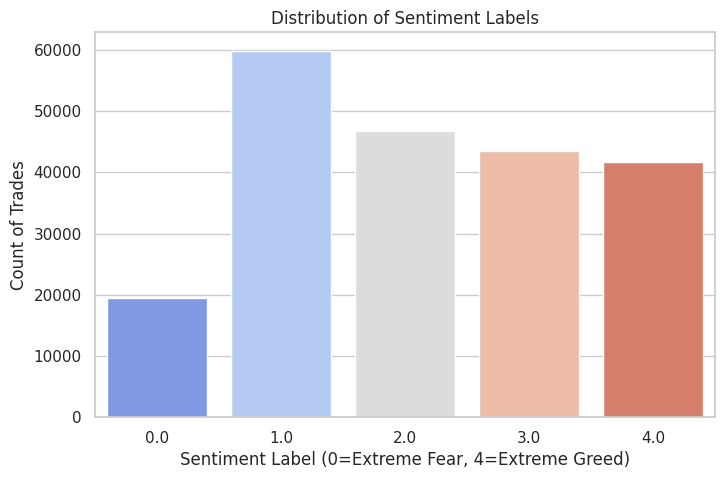

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='sentiment_label', data=merged_df, palette='coolwarm')
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label (0=Extreme Fear, 4=Extreme Greed)")
plt.ylabel("Count of Trades")
plt.show()


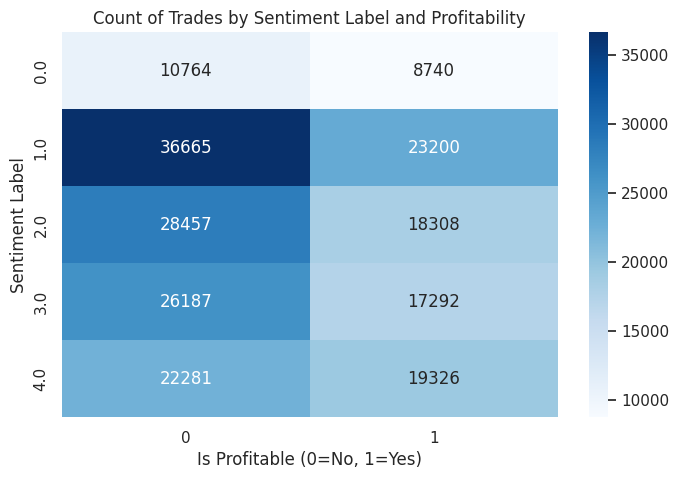

In [ ]:
# Filter rows with non-null values
df_filtered = merged_df.dropna(subset=['sentiment_label', 'is_profitable'])

ct = pd.crosstab(df_filtered['sentiment_label'], df_filtered['is_profitable'])

plt.figure(figsize=(8,5))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title('Count of Trades by Sentiment Label and Profitability')
plt.xlabel('Is Profitable (0=No, 1=Yes)')
plt.ylabel('Sentiment Label')
plt.show()


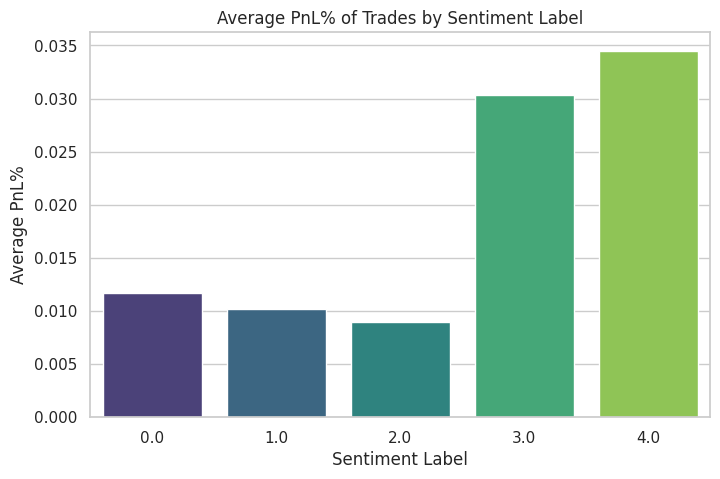

In [ ]:
plt.figure(figsize=(8,5))
avg_pnl = merged_df.groupby('sentiment_label')['pnl_pct_of_notional'].mean()
sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette='viridis')
plt.title("Average PnL% of Trades by Sentiment Label")
plt.xlabel("Sentiment Label")
plt.ylabel("Average PnL%")
plt.show()


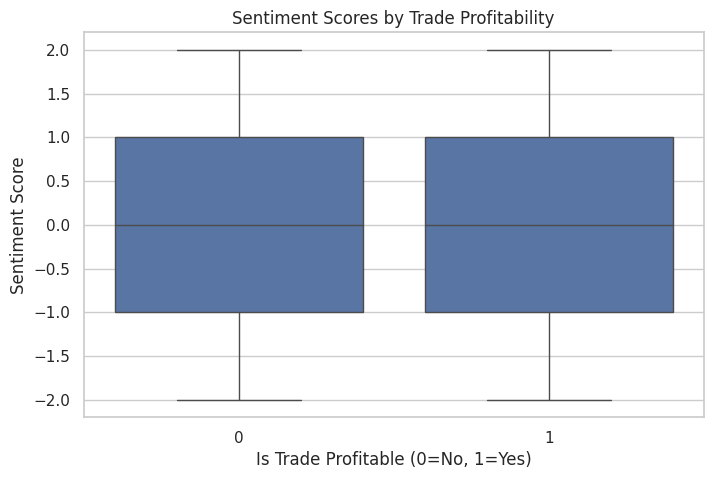

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='is_profitable', y='Sentiment_Score', data=merged_df)
plt.title("Sentiment Scores by Trade Profitability")
plt.xlabel("Is Trade Profitable (0=No, 1=Yes)")
plt.ylabel("Sentiment Score")
plt.show()


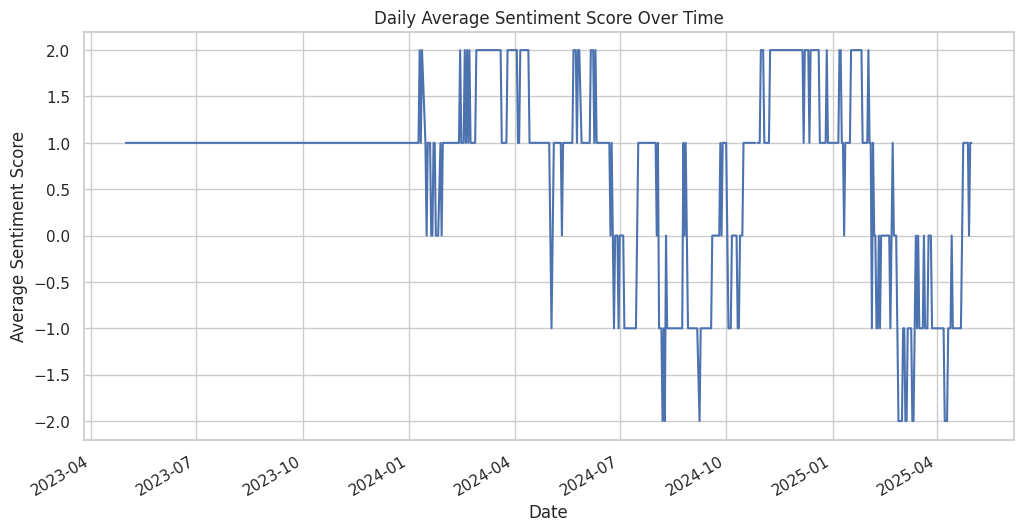

In [ ]:
# Aggregate mean sentiment score by date
daily_sentiment = merged_df.groupby('date_only')['Sentiment_Score'].mean()

plt.figure(figsize=(12,6))
daily_sentiment.plot()
plt.title("Daily Average Sentiment Score Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import mannwhitneyu

# Filter non-null needed columns
df_test = merged_df.dropna(subset=['Sentiment_Score', 'is_profitable'])

profitable_scores = df_test[df_test['is_profitable'] == 1]['Sentiment_Score']
non_profitable_scores = df_test[df_test['is_profitable'] == 0]['Sentiment_Score']

stat, p = mannwhitneyu(profitable_scores, non_profitable_scores, alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat:.4f}, p-value: {p:.4g}")

if p < 0.05:
    print("Result: Significant difference in sentiment scores between profitable and non-profitable trades")
else:
    print("Result: No significant difference detected")


Mann-Whitney U test statistic: 5577500605.0000, p-value: 2.131e-39
Result: Significant difference in sentiment scores between profitable and non-profitable trades


In [ ]:
features = ['Sentiment_Score', 'exec_price', 'size_raw']  # drop leverage

df_model = merged_df.dropna(subset=features + [target])
print("Rows after dropping NaNs in selected features + target:", df_model.shape[0])

X = df_model[features]
y = df_model[target]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['exec_price', 'size_raw']] = scaler.fit_transform(X_scaled[['exec_price', 'size_raw']])

from sklearn.model_selection import train_test_split
import joblib

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

joblib.dump(scaler, 'scaler.joblib')
joblib.dump((X_train, X_test, y_train, y_test), 'train_test_split.joblib')
print("Saved scaler and train-test split artifacts.")


Rows after dropping NaNs in selected features + target: 211220
Train size: (158415, 3)
Test size: (52805, 3)
Saved scaler and train-test split artifacts.
